## Overall Logic
Primairy loop over time, starting from the initial CurrentTime, taking an initial TimeStep
Determine which events are active (Events StartTime < CurrentTime <= Events StopTime)
determine if adjusted TimeStep is necessary (e.g. event StopTime is before CurrentTime + TimeStep) -> adjust TimeStep to StopTime - CurrentTime.
Proces events and determine condition of all tanks at end of time step
Loop over potential triggers, that cause events to start

| Comment: Later we implement: Reset time to different position to capture triggers at right time, Adjust tank conditions to that adjusted situation

Events are on a heap and have: Description, StartTime, StopTime, Duration, FillTank, FillRate, DrainTank, DrainRate
Event StartTime is time of trigger activation. StopTime is StartTime + Duration, Duration is set by the event that is triggered
For some events Duration and StopTime are not known. The event is stopped by a trigger, causing the event to stop
Event are added to the Heap as they are triggered

Event are created by triggers
The first timestep should cause the triggers to create the initial events
Events can occur simultanously, but are then calculated consequetively during the timestep
Triggers are evaluated at the end of processing all events.

Some triggers need to stop an event: add that moment we set the stoptime of that event to CurrentTime, so in the next step the tanks involved in that event are not changing anymore

#Events:
- Description = MakeBatch1
    Duration = MakeBatch_Duration
    FillTank = FeedTank_1
    FillRate = InputBatch_Rate
    DrainTank = FiltrateTank
    DrainRate = FiltrateDischarge_Rate
- Description = MakeBatch2
    Duration = MakeBatch_Duration
    FillTank = FeedTank_2
    FillRate = InputBatch_Rate
    DrainTank = FiltrateTank
    DrainRate = FiltrateDischarge_Rate
- Description = RunEMU1
    Duration = RunEMU_Duration
    FillTank = SlurryTank
    FillRate = OutputEMU_Rate
    DrainTank = FeedTank1
    DrainRate = InputEMU_Rate
- Description = RunEMU2
    Duration = RunEMU_Duration         
    FillTank = SlurryTank
    FillRate = OutputEMU_Rate
    DrainTank = FeedTank2
    DrainRate = InputEMU_Rate
- Description = RunLarox
    Duration = RunLarox_Duration         
    FillTank = FiltrateTank
    FillRate = OutputLarox_Rate
    DrainTank = SlurryTank
    DrainRate = FeedLarox_Rate


| Comment: RunEMU basically runs till trigger stops it (Level_perc of Feedtank1 < 15%)
| Comment: Later we implement: Nested events: Fill, Flush, Wash, Cloth, Cake


#Triggers to add and start event
- If FeedTank1 Level_perc is < 20% AND RunEMU1 is not active AND CurrentTime is between 6:00 and 20:00 -> MakeBatch1
- If FeedTank2 Level_perc is < 20% AND RunEMU2 is not active AND CurrentTime is between 6:00 and 20:00 -> MakeBatch2
- MakeBatch2: If FeedTank2 Level_perc is < 20% AND RunEMU2 is not active AND CurrentTime is between 6:00 and 20:00
- If Feedtank2 Level_perc is < 15% AND Feedtank1 Level_perc is > 50% AND RunEMU2 is active-> RunEMU1 AND StopEMU2
- If Feedtank1 Level_perc is < 15% AND Feedtank2 Level_perc is > 50% AND RunEMU2 is active-> RunEMU2 AND StopEMU1
- If SlurryTank Level_perc is >30% -> RunLarox

| Comment: Later we implement: pause during cycle if slurry < xx or Filtrate is > xx


#Tanks
All tanks have a static MaxVolume_ltrs of 6000 liters.
Each tanks has a dynamic Level_perc and Level_ltrs that changes over the simulation loop. Level_ltrs is affected by FlowRate * TimeStep (=+ for Fill, =- for Drain)
Level_perc = Level_ltrs/MaxVolume_Ltrs

#FlowRates
InputBatch_Rate = 500 l/h
OutputEMU_Rate = 300 l/h
InputEMU_Rate = 300l/h
InputLarox_Rate = 7000 l/h
OutputLarox_Rate  = 7000 l/h
FiltrateDischarge_Rate = 500 l/h

#Durations
MakeBatch_Duration = 300 minutes
RunEMU_Duration = 9999 mintues
RunLarox_Duration = 3 minutes

|Comment: Later we implement: FiltrateDrain: triggered by overall levels

#Initiate
Initiate Tank levels:
Feedtank1 = 15%
Feedtank2 = 80%
Slurrytank = 20%
Filtratetank = 20%
DateTime = Mo 18-augustus-2024 6:00
TimeStep = 5 minutes

#Log
Log Tanklevels and event triggers and event stops, TimeStep length over each timestep

#Monitor statusses:
Batch: Fill_1, 2, pauze
EMU: 1,2, pauze
Larox, Fill, Flush, Wash, Cloth, Cake, Pauze
During each phase certain inlet and outlet flows are active with flowrates
Triggers will cause status-changes (instead of creating event)
pauze can then be set as an event where start_time keeps shifting, or triggers the actual start event when condition for pasuze falls away



Done initializing variables
Done loading functions

Taking a time step from: CurrentTime: 2024-08-18 06:00:00, TimeStep: 0:05:00
No duplicate active events found. 
  Active Events: ['RunEMU2']

Taking a time step from: CurrentTime: 2024-08-18 06:05:00, TimeStep: 0:05:00
No duplicate active events found. 
  Active Events: ['RunEMU2', 'MakeBatch1']

Taking a time step from: CurrentTime: 2024-08-18 06:10:00, TimeStep: 0:05:00
No duplicate active events found. 
  Active Events: ['RunEMU2', 'MakeBatch1']

Taking a time step from: CurrentTime: 2024-08-18 06:15:00, TimeStep: 0:05:00
No duplicate active events found. 
  Active Events: ['RunEMU2', 'MakeBatch1']

Taking a time step from: CurrentTime: 2024-08-18 06:20:00, TimeStep: 0:05:00
No duplicate active events found. 
  Active Events: ['RunEMU2', 'MakeBatch1']

Taking a time step from: CurrentTime: 2024-08-18 06:25:00, TimeStep: 0:05:00
No duplicate active events found. 
  Active Events: ['RunEMU2', 'MakeBatch1', 'RunLarox']

Taking a time 

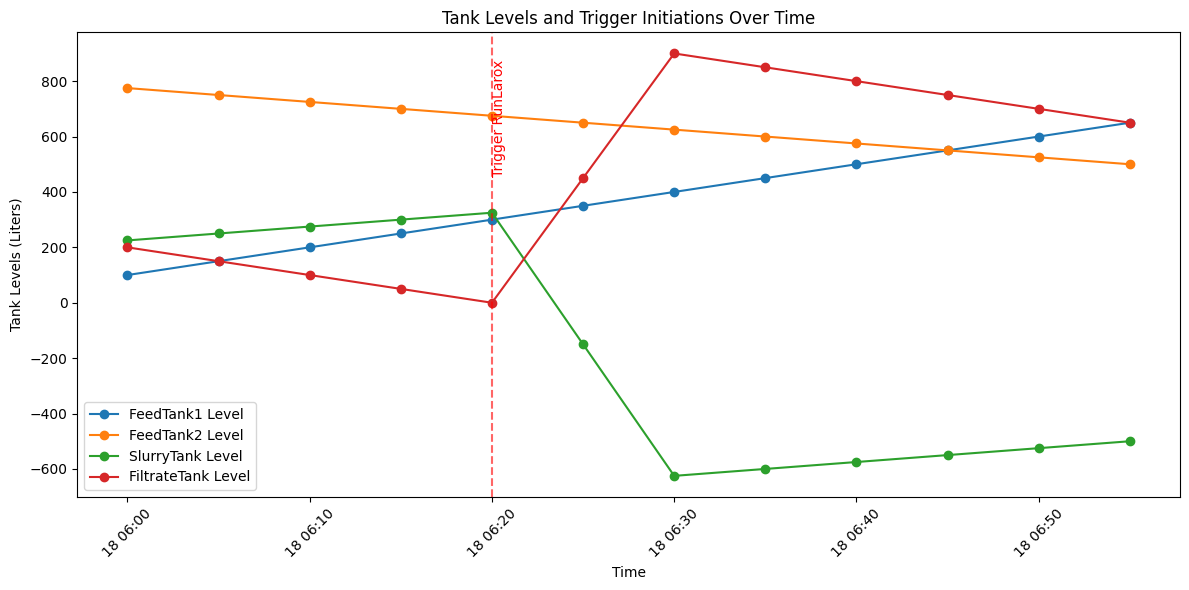

In [41]:
from datetime import datetime, timedelta
import pdb

# Initialize Tanks with their properties
tanks = {
    'FeedTank1': {'MaxVolume_ltrs': 1000, 'Level_ltrs': 100, 'Level_perc': 0.10},  # Updated to 10%
    'FeedTank2': {'MaxVolume_ltrs': 1000, 'Level_ltrs': 800, 'Level_perc': 0.80},
    'SlurryTank': {'MaxVolume_ltrs': 1000, 'Level_ltrs': 200, 'Level_perc': 0.20},
    'FiltrateTank': {'MaxVolume_ltrs': 1000, 'Level_ltrs': 200, 'Level_perc': 0.20},
}
##print(f"tanks: {tanks}")

# Initialize FlowRates (liters per hour)
flow_rates = {
    'InputBatch_Rate': 600, # 10l/min -> 50l/5min, easy to track
    'OutputEMU_Rate': 300, # 5l/min -> 25l/5min, easy to track, 2.5% per 5min, so from 80% to 15% is 26 timesteps..
    'InputEMU_Rate': 300,
    'InputLarox_Rate': 6000, # 100l/min -> 500l/5min, easy to track
    'OutputLarox_Rate': 6000,
    'FiltrateDischarge_Rate': 600
}
##print(f"flow_rates: {flow_rates}")

# Initialize Durations (in minutes)
durations = {
    'MakeBatch_Duration': 300,  # Updated to 300 minutes
    'RunEMU_Duration': 9999,  # EMU runs until a trigger stops it
    'RunLarox_Duration': 10,
}
##print(f"durations: {durations}")


# Initialize Simulation Variables
StartTime = datetime(2024, 8, 18, 6, 0)
CurrentTime = StartTime
TimeStep = timedelta(minutes=5)
EndSimulation = StartTime + timedelta(hours=1)  # Simulate from 6:00 to 20:00

# Initialize Events Matrix (Start with MakeBatch1 and RunEMU2 active)
events = [
     {'Description': 'RunEMU2', 'StartTime': StartTime, 'StopTime': None, 'FillTank': 'SlurryTank', 'FillRate': flow_rates['OutputEMU_Rate'], 'DrainTank': 'FeedTank2', 'DrainRate': flow_rates['InputEMU_Rate']},
     {'Description': 'MakeBatch1', 'StartTime': StartTime + timedelta(minutes=3), 'StopTime': StartTime + timedelta(minutes=3 + durations['MakeBatch_Duration']), 'FillTank': 'FeedTank1', 'FillRate': flow_rates['InputBatch_Rate'], 'DrainTank': 'FiltrateTank', 'DrainRate': flow_rates['FiltrateDischarge_Rate']}
]
print("Done initializing variables")

# Generic function to update Level_perc
def update_tank_level_percentage(tank_name):
    tank = tanks[tank_name]
    tank['Level_perc'] = tank['Level_ltrs'] / tank['MaxVolume_ltrs']

# Function to process events
def process_event(current_time, event):
    time_step_minutes = TimeStep.total_seconds() / 60  # Convert TimeStep to minutes

    if event['FillTank']:
        tanks[event['FillTank']]['Level_ltrs'] += event['FillRate'] * time_step_minutes / 60
        update_tank_level_percentage(event['FillTank'])

    if event['DrainTank']:
        tanks[event['DrainTank']]['Level_ltrs'] -= event['DrainRate'] * time_step_minutes / 60
        update_tank_level_percentage(event['DrainTank'])

# Function to check for and stop an active RunEMU event
def switch_emu(current_time, stop_event, start_event_desc, start_fill_tank, start_drain_tank):
    active_emu = [event for event in events if event['Description'].startswith('RunEMU') and event['StopTime'] is None]
    if len(active_emu) != 1:
        raise Exception("There should only be one active RunEMU event. Found: {}".format(len(active_emu)))

    # Stop the currently active RunEMU event
    active_emu[0]['StopTime'] = current_time
    #print(f"Stopping {active_emu[0]['Description']} at time {current_time}")

    # Start the other RunEMU event
    events.append({
        'Description': start_event_desc,
        'StartTime': current_time + TimeStep,
        'StopTime': None,
        'FillTank': start_fill_tank,
        'FillRate': flow_rates['OutputEMU_Rate'],
        'DrainTank': start_drain_tank,
        'DrainRate': flow_rates['InputEMU_Rate']
    })
    #print(f"Starting {start_event_desc} at time {current_time}")

# Function to check triggers and add new events
trigger_log = []
def check_triggers(current_time):
    # Check for MakeBatch1
    if tanks['FeedTank1']['Level_perc'] < 0.20:
        active_makebatch1 = [event for event in events if event['Description'] == 'MakeBatch1' and (event['StopTime'] is None or event['StopTime'] > CurrentTime)] #check if Makebatch1 isn't already active or sheduled for the future
        if len(active_makebatch1) == 0:
            trigger_log.append((current_time, 'Trigger MakeBatch1'))
            #print(f"Triggering MakeBatch1 at time {current_time}")
            events.append({
                'Description': 'MakeBatch1',
                'StartTime': current_time  + TimeStep,
                'StopTime': current_time  + TimeStep + timedelta(minutes=durations['MakeBatch_Duration']),
                'FillTank': 'FeedTank1',
                'FillRate': flow_rates['InputBatch_Rate'],
                'DrainTank': 'FiltrateTank',
                'DrainRate': flow_rates['FiltrateDischarge_Rate']
            })

    # Check for MakeBatch2
    if tanks['FeedTank2']['Level_perc'] < 0.20:
        active_makebatch2 = [event for event in events if event['Description'] == 'MakeBatch2' and (event['StopTime'] is None or event['StopTime'] > CurrentTime)]
        if len(active_makebatch2) == 0:
            trigger_log.append((current_time, 'Trigger MakeBatch2'))
            #print(f"Triggering MakeBatch2 at time {current_time}")
            events.append({
                'Description': 'MakeBatch2',
                'StartTime': current_time + TimeStep,
                'StopTime': current_time + TimeStep + timedelta(minutes=durations['MakeBatch_Duration']),
                'FillTank': 'FeedTank2',
                'FillRate': flow_rates['InputBatch_Rate'],
                'DrainTank': 'FiltrateTank',
                'DrainRate': flow_rates['FiltrateDischarge_Rate']
            })

    # Stop RunEMU1 if FeedTank1 < 15% and trigger RunEMU2
    if tanks['FeedTank1']['Level_perc'] < 0.15:
        active_runemu1 = [event for event in events if event['Description'] == 'RunEMU2' and (event['StopTime'] is None or event['StopTime'] > CurrentTime)] #check if runemu2 isn't already active.
        if len(active_runemu1) == 0:
          trigger_log.append((current_time, 'Trigger RunEMU2'))
          #print(f"Triggering RunEMU2 at time {current_time}")
          switch_emu(current_time, 'RunEMU1', 'RunEMU2', 'SlurryTank', 'FeedTank2')

    # Stop RunEMU2 if FeedTank2 < 15% and trigger RunEMU1
    if tanks['FeedTank2']['Level_perc'] < 0.15:
        active_runemu2 = [event for event in events if event['Description'] == 'RunEMU1'and (event['StopTime'] is None or event['StopTime'] > CurrentTime)]
        if len(active_runemu2) == 0:
          trigger_log.append((current_time, 'Trigger RunEMU1'))
          #print(f"Triggering RunEMU1 at time {current_time}")
          switch_emu(current_time, 'RunEMU2', 'RunEMU1', 'SlurryTank', 'FeedTank1')

    # Trigger RunLarox when SlurryTank > 30%
    if tanks['SlurryTank']['Level_perc'] > 0.30:
        active_runlarox = [event for event in events if event['Description'] == 'RunLarox' and (event['StopTime'] is None or event['StopTime'] > CurrentTime)] #check if runlarox isn't already active
        if len(active_runlarox) == 0:
            #pdb.set_trace()
            #print(f"Triggering RunLarox at time {current_time}")
            #input("press enter")
            trigger_log.append((current_time, 'Trigger RunLarox'))
            events.append({
                'Description': 'RunLarox',
                'StartTime': current_time + TimeStep,
                'StopTime': current_time + TimeStep + timedelta(minutes=durations['RunLarox_Duration']),
                'FillTank': 'FiltrateTank',
                'FillRate': flow_rates['OutputLarox_Rate'],
                'DrainTank': 'SlurryTank',
                'DrainRate': flow_rates['InputLarox_Rate']
            })

##print(f"events: {events}")
print("Done loading functions")

# Simulation Loop
log = []
while CurrentTime < EndSimulation:
    print(f"\nTaking a time step from: CurrentTime: {CurrentTime}, TimeStep: {TimeStep}")
    event_descriptions = [event['Description'] for event in events]
    # #print active event descriptions
    ##print(f"All Events: {event_descriptions}")

    # Filter all active events within the current time step
    active_events = [event for event in events if event['StartTime'] <= CurrentTime and (event['StopTime'] is None or event['StopTime'] > CurrentTime)]

    # Check for duplicate descriptions in active_events
    active_event_descriptions = [event['Description'] for event in active_events]
    duplicates = {desc for desc in active_event_descriptions if active_event_descriptions.count(desc) > 1}
    if duplicates:
        raise Exception(f"Duplicate active events found for descriptions: {duplicates}")
    else:
      # #print active event descriptions
      print(f"No duplicate active events found. \n  Active Events: {active_event_descriptions}")
      #pdb.set_trace()


    # Process all active events
    for event in active_events:
        #print(f"\n Processing event: {event}")
        process_event(CurrentTime, event)
        #print(f"  Tanks after processing event: {tanks}")
        # Check triggers after processing events
        check_triggers(CurrentTime)
        #print(f"  Events after processing triggers: {events}")

    #for tank, status in tanks.items():
    #    print(f"  {tank}: Level {status['Level_ltrs']}L ({status['Level_perc']*100:.2f}%)")


    import copy
    #log.append((CurrentTime, [event['Description'] for event in active_events], copy.deepcopy(tanks)))
    log.append((CurrentTime, [event['Description'] for event in active_events], copy.deepcopy(tanks), copy.deepcopy(trigger_log)))
    trigger_log.clear()  # Clear trigger log after logging


    # Move time forward
    CurrentTime += TimeStep

    # Breakpoints for manual inspection
    #print(f"\nDone processing events and triggers, CurrentTime: {CurrentTime}")
    #pdb.set_trace()

print("Done with TimeLoop\n")


# Output the log for each step
for entry in log:
    time, event_descriptions, tank_status, triggers = entry
    print(f"Time: {time}, Events: {event_descriptions}")

    # Print the tank levels
    for tank, status in tank_status.items():
        print(f"  {tank}: Level {status['Level_ltrs']}L ({status['Level_perc']*100:.2f}%)")

    # Print the triggers if any
    if triggers:
        print("  Triggers:")
        for trigger in triggers:
            print(f"    {trigger[1]} triggered at {trigger[0]}")

print("Done printing the log\n")


import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for plotting
times = [entry[0] for entry in log]  # Extract times from the log
tank_levels = {
    'FeedTank1': [entry[2]['FeedTank1']['Level_ltrs'] for entry in log],
    'FeedTank2': [entry[2]['FeedTank2']['Level_ltrs'] for entry in log],
    'SlurryTank': [entry[2]['SlurryTank']['Level_ltrs'] for entry in log],
    'FiltrateTank': [entry[2]['FiltrateTank']['Level_ltrs'] for entry in log]
}

# Prepare data for trigger marks
trigger_times = []
trigger_labels = []

for entry in log:
    time, _, _, triggers = entry
    for trigger in triggers:
        trigger_times.append(time)
        trigger_labels.append(trigger[1])

# Convert the times to a more plot-friendly format
times_numeric = pd.to_datetime(times)

# Plotting
plt.figure(figsize=(12, 6))

# Plot each tank's level over time
plt.plot(times_numeric, tank_levels['FeedTank1'], label='FeedTank1 Level', linestyle='-', marker='o')
plt.plot(times_numeric, tank_levels['FeedTank2'], label='FeedTank2 Level', linestyle='-', marker='o')
plt.plot(times_numeric, tank_levels['SlurryTank'], label='SlurryTank Level', linestyle='-', marker='o')
plt.plot(times_numeric, tank_levels['FiltrateTank'], label='FiltrateTank Level', linestyle='-', marker='o')

# Add vertical lines and labels for trigger initiations
for trigger_time, trigger_label in zip(trigger_times, trigger_labels):
    plt.axvline(pd.to_datetime(trigger_time), color='red', linestyle='--', alpha=0.6)
    plt.text(pd.to_datetime(trigger_time), plt.ylim()[1] * 0.9, trigger_label, rotation=90, verticalalignment='top', color='red')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Tank Levels (Liters)')
plt.title('Tank Levels and Trigger Initiations Over Time')
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [42]:
import plotly.graph_objs as go
import plotly.express as px

fig = go.Figure()

# Add tank levels to the interactive plot
fig.add_trace(go.Scatter(x=times_numeric, y=tank_levels['FeedTank1'], mode='lines', name='FeedTank1'))
fig.add_trace(go.Scatter(x=times_numeric, y=tank_levels['FeedTank2'], mode='lines', name='FeedTank2'))
fig.add_trace(go.Scatter(x=times_numeric, y=tank_levels['SlurryTank'], mode='lines', name='SlurryTank'))
fig.add_trace(go.Scatter(x=times_numeric, y=tank_levels['FiltrateTank'], mode='lines', name='FiltrateTank'))

# Add vertical lines for triggers
for trigger_time, trigger_label in zip(trigger_times, trigger_labels):
    fig.add_vline(x=trigger_time, line=dict(color='red', width=2))
    fig.add_annotation(x=trigger_time, y=1, text=trigger_label, showarrow=False, yshift=10, font=dict(color='red'))

fig.update_layout(title='Tank Levels and Triggers Over Time', xaxis_title='Time', yaxis_title='Tank Levels (Liters)')
fig.show()
